In [2]:
!pip install pennylane

In [3]:
import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys

# Setting our constants
sys.path.append('..')

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [4]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy

--2026-01-06 07:02:54--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32896 (32K) [application/octet-stream]
Saving to: ‘train_X.npy’

train_X.npy         100%[===================>]  32.12K  --.-KB/s    in 0.002s  

2026-01-06 07:02:54 (13.2 MB/s) - ‘train_X.npy’ saved [32896/32896]

--2026-01-06 07:02:54--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256 [

In [5]:
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

In [9]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Inference (Model Prediction) - 기존 유지
# ==========================================
def get_predictions(model, inputs):
    """Run inference on inputs using the trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
    return predicted_labels.cpu().numpy()

def data_to_tensor(X, y):
    tensor_X = torch.tensor(X, dtype=torch.complex64)
    tensor_y = torch.tensor(y, dtype=torch.long)
    return tensor_X, tensor_y

t_train_X, t_train_y = data_to_tensor(train_X, train_y)
train_dataset = TensorDataset(t_train_X, t_train_y)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [14]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader, Subset
import copy
import json

# ==========================================
# 0. 데이터 준비
# ==========================================
# (train_X, train_y가 이미 로드되어 있다고 가정)
t_X = torch.tensor(train_X, dtype=torch.float32)
t_y = torch.tensor(train_y, dtype=torch.long)
full_dataset = TensorDataset(t_X, t_y)

# ==========================================
# 1. QNode 정의 (규칙 준수: 2 Qubit Probability)
# ==========================================
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

# ★ 중요: 2개의 큐비트만 측정합니다.
# 어떤 큐비트를 측정할지 결정 (여기서는 0, 1번 사용)
measure_wires = [0, 1]

@qml.qnode(dev, interface="torch")
def circuit_layer(inputs, weights):
    # [Encoding]
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0., normalize=True)

    # [Variational Layers]
    # 파라미터 수: 5 layers * 8 qubits * 3 params = 120개 (Baseline과 동일)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits), ranges=[1, 2, 3, 4, 1])

    # [Measurement - 규칙 수정]
    # 2개 큐비트의 확률(Probability)을 반환합니다. -> 4개의 값 [P(00), P(01), P(10), P(11)]
    return qml.probs(wires=measure_wires)

# ==========================================
# 2. Hybrid Model Class
# ==========================================
class HybridQNN(nn.Module):
    def __init__(self, n_layers=5):
        super().__init__()
        self.n_layers = n_layers
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}

        self.q_layer = qml.qnn.TorchLayer(circuit_layer, weight_shapes)

        # 가중치 별칭 (시각화용)
        self.params = self.q_layer.weights

    def forward(self, x):
        # probs 출력: [batch_size, 4], 값 범위 0.0 ~ 1.0 (합은 1.0)
        probs = self.q_layer(x)

        # [Logit 변환]
        # CrossEntropyLoss는 입력으로 Logits(log-probabilities)를 기대합니다.
        # 확률값에 아주 작은 수(epsilon)를 더해 log를 취해줍니다.
        # 이렇게 하면 모델이 확률 분포 자체를 학습하게 됩니다.
        eps = 1e-8
        logits = torch.log(probs + eps)

        return logits

# ==========================================
# 3. 학습 (전체 데이터 Retraining)
# ==========================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 전체 데이터 학습
train_loader = DataLoader(full_dataset, batch_size=4, shuffle=True)

model = HybridQNN(n_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print("🚀 Training Final Model (Rule Compliant)...")
n_epochs = 200

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X) # Logits 출력

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_X.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == batch_y).item()
        total += batch_y.size(0)

    if epoch % 20 == 0:
        epoch_loss = total_loss / total
        epoch_acc = correct / total
        print(f"Epoch {epoch:03d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

print("✅ Training Complete.")

# ==========================================
# 4. JSON 제출 파일 생성 (규칙 준수)
# ==========================================

# 학습된 파라미터 추출
final_params = model.params.detach().cpu().numpy()

# QASM 생성을 위한 QNode (Encoding 제외, Ansatz + Measurement)
@qml.qnode(dev, interface='torch')
def Export_Circuit(params):
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits), ranges=[1, 2, 3, 4, 1])
    # OpenQASM 변환 시에는 return 문을 비워두거나 측정만 명시합니다.
    # 하지만 PennyLane to_openqasm은 게이트 위주로 변환하므로 로직만 있으면 됩니다.

# QASM 변환
qasm_str = qml.to_openqasm(Export_Circuit, measure_all=False)(final_params)

# ★ 중요: 규칙에 맞게 2개의 큐비트 인덱스 저장
submission_measurements = measure_wires # [0, 1]

submission_data = {
    "qasm": qasm_str,
    "measurements": submission_measurements
}

with open("./baseline.json", "w") as f:
    json.dump(submission_data, f)

print(f"\n✅ Created 'baseline.json' with measurements on wires {submission_measurements}")
print("--- QASM Preview ---")
print("\n".join(qasm_str.split('\n')[:5]))

Using device: cuda
🚀 Training Final Model (Rule Compliant)...
Epoch 020 | Loss: 0.9697 | Acc: 0.8750
Epoch 040 | Loss: 0.9210 | Acc: 0.9375
Epoch 060 | Loss: 0.8837 | Acc: 0.9375
Epoch 080 | Loss: 0.8668 | Acc: 1.0000
Epoch 100 | Loss: 0.8560 | Acc: 1.0000
Epoch 120 | Loss: 0.8479 | Acc: 1.0000
Epoch 140 | Loss: 0.8380 | Acc: 1.0000
Epoch 160 | Loss: 0.8296 | Acc: 1.0000
Epoch 180 | Loss: 0.8265 | Acc: 1.0000
Epoch 200 | Loss: 0.8252 | Acc: 1.0000
✅ Training Complete.

✅ Created 'baseline.json' with measurements on wires [0, 1]
--- QASM Preview ---
OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
rz(4.2291164) q[0];


(<Figure size 500x900 with 1 Axes>, <Axes: >)

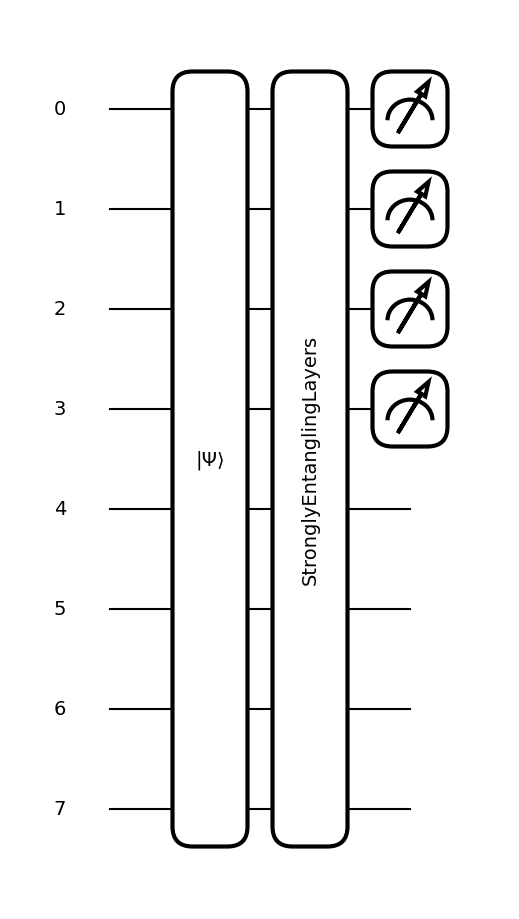

In [13]:
qml.draw_mpl(linear_2qubit_block)(batch_X,model.params)

In [ ]:
import json

# 1. Specify measurement qubits
measurements = [6, 7]

# 2. Extract trained parameters
params = model.params.detach().cpu().numpy()

# 3. Define circuit for QASM conversion (Ansatz only, no StatePrep or Measurement)
@qml.qnode(dev, interface='torch')
def Classifier(params):
    Quantum_classifier(params)

# 4. Generate OpenQASM string
qasm_data = qml.to_openqasm(Classifier, measure_all=False)(params)

print(f"✅ Measurement Qubits: {measurements}")
print(f"✅ QASM Data Generated (Length: {len(qasm_data)} characters)")
print("--- QASM Preview (First 10 lines) ---")
print("\n".join(qasm_data.split('\n')[:10]))


with open("./baseline.json", "w") as f:
    json.dump({
        "qasm": qasm_data,
        "measurements": measurements
    }, f)
print("✅ Submission file 'baseline.json' created.")

✅ Measurement Qubits: [6, 7]
✅ QASM Data Generated (Length: 3040 characters)
--- QASM Preview (First 10 lines) ---
OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
rz(0.057319336) q[0];
ry(-0.0026217776) q[0];
rz(-0.024432804) q[0];
rz(0.27092808) q[1];
ry(0.002669789) q[1];
rz(-0.28873712) q[1];
✅ Submission file 'baseline.json' created.


In [ ]:
from google.colab import files
files.download('baseline.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>